In [1]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt

from model import lorenz63_fdm
from assimilation import OI, ExtendedKF, EnKF, M3DVar

In [2]:
X_nature = np.load('./data/X_nature.npy')
X_ini = np.load('./data/X_ini.npy')
ts = np.load('./data/time_span.npy')
Pb = np.load('./data/Pb.npy')
R = np.load('./data/R.npy')

In [3]:
dt = 0.01
obs_intv = 8

In [4]:
# generate initial ensemble
N_ens = 30
rng = np.random.RandomState(42)
X_ens_ini = rng.multivariate_normal(X_ini.ravel(), Pb, size=N_ens).T  # (3, N_ens)

In [5]:
def RMSE(forecast, nature):
    return np.sqrt(np.mean((forecast-nature)**2, axis=0))

# Assimilate normal observations

0.9094363928307894


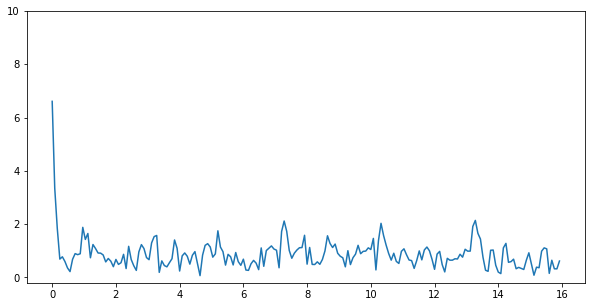

In [6]:
# normal observation
X_obs = np.load('./data/obs_normal.npy')

enkf = EnKF(lorenz63_fdm, dt)
enkf.list_params()
params = {
    'X_ens_ini': X_ens_ini,
    'obs': X_obs,
    'obs_interv': obs_intv,
    'R': R,
    'H_func': lambda arr: arr,
    'alpha': 0.3,
    'inflat': 1.4
}
enkf.set_params(**params)
enkf.cycle()

ens_mean = enkf.analysis.mean(axis=0)
rmse_enkf = RMSE(ens_mean, X_nature)

plt.figure(figsize=(10, 5))
plt.plot(ts[::8], rmse_enkf[::8])
plt.ylim([-0.2, 10])
print(rmse_enkf.mean())

# Gamma distribution

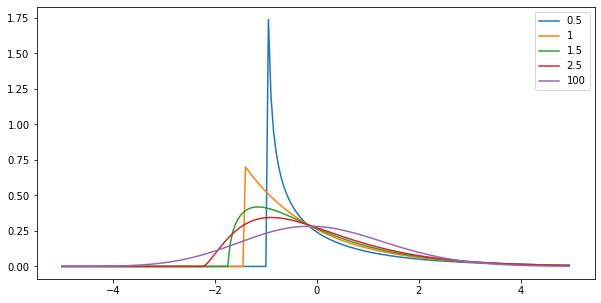

In [7]:
from scipy.stats import gamma

plt.figure(figsize=(10, 5))

x = np.arange(-5, 5, 0.05)
alphas = [0.5, 1, 1.5, 2.5, 100]
for alpha in alphas:
    beta = np.sqrt(2/alpha)
    loc = -np.sqrt(2*alpha)
    pdf = gamma.pdf(x, alpha, loc=loc, scale=beta)
    plt.plot(x, pdf, label=f'{alpha}')
plt.legend()

### Generate observations

In [8]:
ex_obs_dict = {}

alphas = [0.5, 1, 1.5, 2.5, 100]
for alpha in alphas:
    beta = np.sqrt(2/alpha)
    loc = -np.sqrt(2*alpha)
    samples = gamma.rvs(alpha, loc=loc, scale=beta, size=X_nature.shape)
    
    samples_c = samples.copy()
    samples_c[:,::obs_intv] = 0
    samples = samples - samples_c
    X_obserr = samples
        
    X_obs = X_nature + X_obserr
    X_obs = X_obs[:,::obs_intv]
    
    key = f'{alpha:.1f}'
    ex_obs_dict[key] = X_obs
    
ex_obs_dict.keys()

dict_keys(['0.5', '1.0', '1.5', '2.5', '100.0'])

### Assimilate gamma observations

0.5 0.8779487735454012 0.40095342459169525
1.0 0.8073220439285476 0.3106215277168667
1.5 0.8455691690817936 0.3780880917159288
2.5 0.9755343485565401 0.3892145926506988
100.0 0.9413744256944642 0.38585591632676947


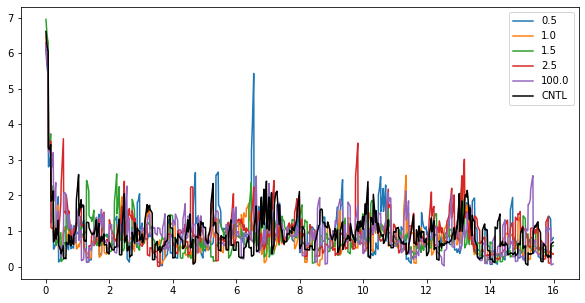

In [22]:
plt.figure(figsize=(10, 5))

rmse_mean = []
rmse_var = []
for key, obs in ex_obs_dict.items():
    enkf = EnKF(lorenz63_fdm, dt)
    enkf.list_params()
    params = {
        'X_ens_ini': X_ens_ini,
        'obs': obs,
        'obs_interv': obs_intv,
        'R': R,
        'H_func': lambda arr: arr,
        'alpha': 0.3,
        'inflat': 1.4
    }
    enkf.set_params(**params)
    enkf.cycle()

    ens_mean = enkf.analysis.mean(axis=0)
    rmse = RMSE(ens_mean, X_nature)

    plt.plot(ts, rmse, label=key)
    print(key, rmse.mean(), rmse.var())
    rmse_mean.append(rmse.mean())
    rmse_var.append(rmse.var())

plt.plot(ts, rmse_enkf, 'k', label='CNTL')
plt.legend();

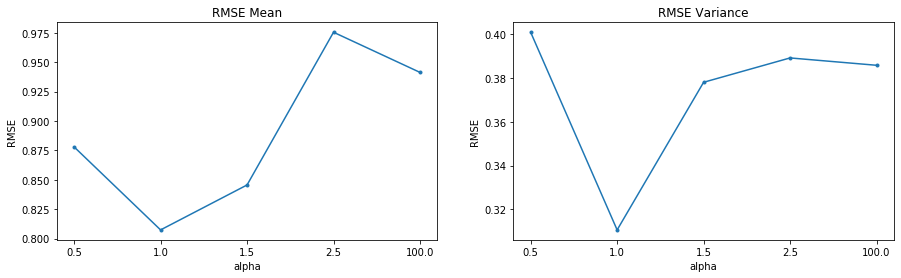

In [23]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

axs[0].plot(rmse_mean, '.-')
axs[0].set_title('RMSE Mean')
axs[0].set_xticks(list(range(len(rmse_mean))))
axs[0].set_xticklabels(ex_obs_dict.keys())
axs[0].set_xlabel('alpha')
axs[0].set_ylabel('RMSE')

axs[1].plot(rmse_var, '.-')
axs[1].set_title('RMSE Variance')
axs[1].set_xticks(list(range(len(rmse_mean))))
axs[1].set_xticklabels(ex_obs_dict.keys())
axs[1].set_xlabel('alpha')
axs[1].set_ylabel('RMSE');

In [14]:
ex_alpha

[0.5, 1.0, 1.5, 2.5, 100.0]

# Cauchy

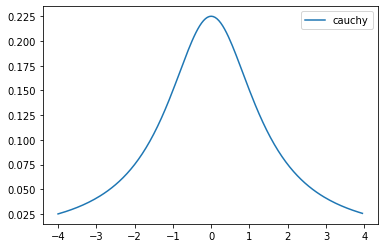

In [118]:
from scipy.stats import cauchy, norm

x = np.arange(-4, 4, 0.05)
plt.plot(x, cauchy.pdf(x, scale=np.sqrt(2)), label='cauchy')
plt.legend();

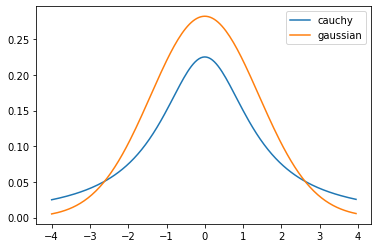

In [119]:
x = np.arange(-4, 4, 0.05)
plt.plot(x, cauchy.pdf(x, scale=np.sqrt(2)), label='cauchy')
plt.plot(x, norm.pdf(x, scale=np.sqrt(2)), label='gaussian')
plt.legend();

### Generate chauchy observation

In [172]:
samples = cauchy.rvs(scale=np.sqrt(2), size=X_nature.shape)
   
samples_c = samples.copy()
samples_c[:,::obs_intv] = 0
samples = samples - samples_c
X_obserr = samples
        
X_obs = X_nature + X_obserr
X_obs = X_obs[:,::obs_intv]

6.373003296956912 172.9291869204287


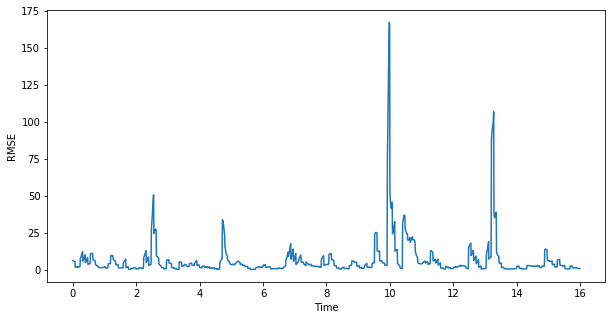

In [173]:
plt.figure(figsize=(10, 5))

enkf = EnKF(lorenz63_fdm, dt)
params = {
    'X_ens_ini': X_ens_ini,
    'obs': X_obs,
    'obs_interv': obs_intv,
    'R': R,
    'H_func': lambda arr: arr,
    'alpha': 0.3,
    'inflat': 1.4
}
enkf.set_params(**params)
enkf.cycle()

ens_mean = enkf.analysis.mean(axis=0)
rmse_enkf = RMSE(ens_mean, X_nature)

plt.plot(ts, rmse_enkf)
plt.xlabel('Time')
plt.ylabel('RMSE')
print(rmse_enkf.mean(), rmse_enkf.var())

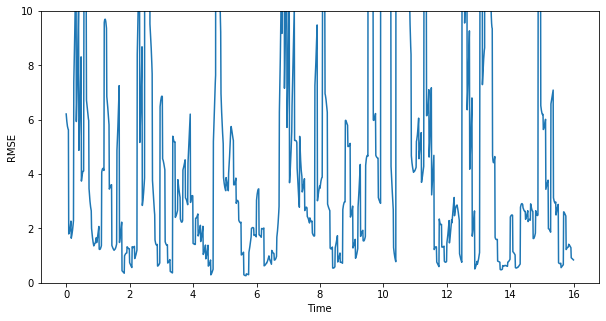

In [174]:
plt.figure(figsize=(10, 5))
plt.plot(ts, rmse_enkf)
plt.xlabel('Time')
plt.ylabel('RMSE')
plt.ylim([0, 10]);

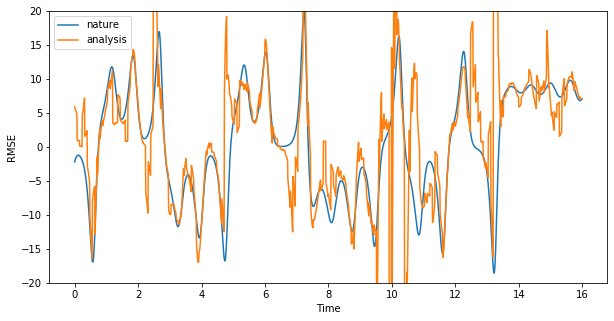

In [175]:
plt.figure(figsize=(10, 5))
plt.plot(ts, X_nature[0,:], label='nature')
plt.plot(ts, ens_mean[0,:], label='analysis')
plt.xlabel('Time')
plt.ylabel('RMSE')
plt.legend()
plt.ylim([-20, 20]);

In [176]:
print(X_obserr.max(), X_obserr.min())

125.6107227046052 -206.62363009567858


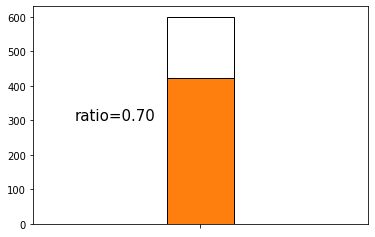

In [177]:
std = np.sqrt(2)
obserr_no0 = X_obserr[:,::obs_intv].ravel()
total_size = obserr_no0.size
within_size = np.sum((obserr_no0 >= -2*std) & (obserr_no0 <= 2*std))

plt.bar(0, total_size, facecolor='white', edgecolor='k')
plt.bar(0, within_size, edgecolor='k')
plt.xlim([-2, 2])
plt.xticks([0], [])
plt.text(-1.5, 300, f'ratio={within_size/total_size:.2f}', fontsize=15);

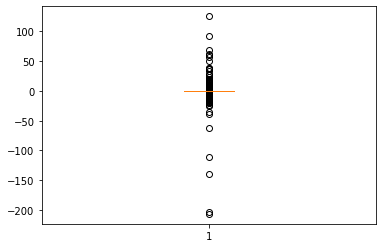

In [178]:
plt.boxplot(X_obserr.ravel());

(-100, 100)

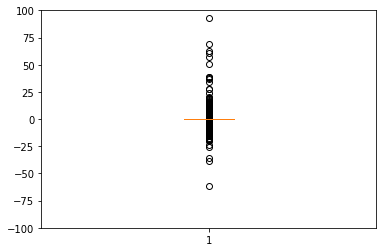

In [179]:
plt.boxplot(X_obserr.ravel())
plt.ylim([-100, 100])

### QC for cauchy

#### Just simply replace the original observation by truth value if the observation value is greater than |N$\sqrt{2}$|, N=2,3,4,5.

N=2, RMSE mean=0.7677, RMSE variance=0.3423
N=3, RMSE mean=0.8081, RMSE variance=0.3072
N=4, RMSE mean=0.9241, RMSE variance=0.3904
N=5, RMSE mean=0.9691, RMSE variance=0.4638


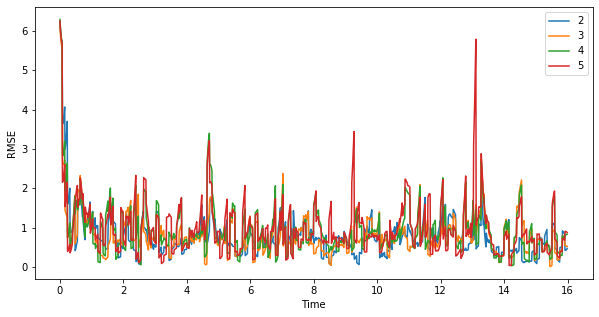

In [201]:
plt.figure(figsize=(10, 5))

obsqc = {}
for N in range(2, 6):
    std = np.sqrt(2)
    X_obserr_qc = X_obserr.copy()
    X_obserr_qc[np.abs(X_obserr) >= N*std] = 0

    X_obs_qc = X_nature + X_obserr_qc
    X_obs_qc = X_obs_qc[:,::obs_intv]
    obsqc[N] = X_obs_qc

    enkf = EnKF(lorenz63_fdm, dt)
    params = {
        'X_ens_ini': X_ens_ini,
        'obs': X_obs_qc,
        'obs_interv': obs_intv,
        'R': R,
        'H_func': lambda arr: arr,
        'alpha': 0.3,
        'inflat': 1.4
    }
    enkf.set_params(**params)
    enkf.cycle()

    ens_mean = enkf.analysis.mean(axis=0)
    rmse_enkf = RMSE(ens_mean, X_nature)
    plt.plot(ts, rmse_enkf, label=str(N))
    print(f'N={N}, RMSE mean={rmse_enkf.mean():.4f}, RMSE variance={rmse_enkf.var():.4f}')
    
plt.legend()
plt.xlabel('Time')
plt.ylabel('RMSE');

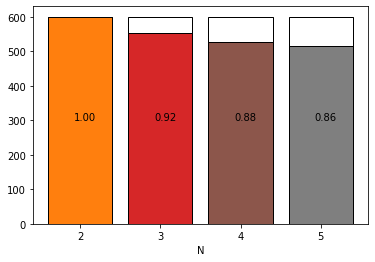

In [215]:
std = np.sqrt(2)
for N, obsq in obsqc.items():
    obsq_err = obsq - X_nature[:,::obs_intv]
    
    total_size = obsq_err.size
    within_size = np.sum((obsq_err >= -2*std) & (obsq_err <= 2*std))
    
    plt.bar(N, total_size, facecolor='white', edgecolor='k')
    plt.bar(N, within_size, edgecolor='k')
    plt.text(N-0.08, 300, f'{within_size/total_size:.2f}')

plt.xticks([i for i in range(2, 6)])
plt.xlabel('N');